**Implementation of the Differential Attack on the Toy Cipher **

First Run--> Cell 1 --> DDT Table --> Attack

In [5]:
import binascii
import math
import itertools
import random
import numpy as np


#function for converting int to hex
def InttoHex(num):
  ans = hex(num)
  return ans[2:len(ans)]

#function for converting hex to binary
def HextoBin(num):
   ans = int(num,16)
   bin_num = format(ans,'016b')
   return bin_num

#bintohex conversion   
def BintoHex(num):
  ans = int(num,2)
  hex_num = format(ans, '04x')
  return hex_num

#Permutation step in the SPN
def permute(num):
  ans = num[pbox[0]-1]
  for i in range(1,16):
    ans = ans + num[pbox[i]-1]
  return ans

#Substitution Box Function
def subbox(x):
  y = sbox[int(x[0],16)]
  for j in range(1,4):
    y = y + sbox[int(x[j],16)]
  return y

#Function that does the key mixing
def keymixer(hex_num,index):
      x=hex_num
      i=index
      Ki = Kh[i*4:4*i+4]
      #p xor key
      x = format(int(x,16)^int(Ki,16),'04x')
      #x = hex(x)
      return x

#Defining encrypt function

def encrypt(p):
    x = p

    for i in range(0,4):

      #key mixing: p xor ki
      kmod=keymixer(x,i)

      

      #call to sbox
      sout=subbox(kmod)


      #Calling Permute
      #no permutation after last sbox (following schema)
      if i!=3:
        #convert message in binary -> permute -> hex again
        x = BintoHex(permute(HextoBin(sout)))
      else:
        x = sout

    #last round key mixing
    x = keymixer(x,4)

    return x

#SPN structure
sbox = ["e","4","d","1","2","f","b","8","3","a","6","c","5","9","0","7"]
pbox = [1,5,9,13,2,6,10,14,3,7,11,15,4,8,12,16]

#for future improvements
# sbox = {"1": "e","2":"4","3":"d","4": "1","5": "2","6":"f","6": "b","7": "8","8": "3","9": "b","10": "6","11": "d","12": "5","13": "a","14": "0","15": "7"}
# pbox = ["1": 1,"2": 5,"3": 9,"4": 13,"5": 2,"6": 6,"7": 10,"8": 14,"9": 3,"10": 7,"11": 11,"12": 15,"13": 4,"14": 8,"15": 12,"16": 16]


##Creating DDT Table


In [6]:
#substitution layer only for one sbox
def subbox1(x):
  y = sbox[int(x[0],16)]
  return y

def create_ddt():
  #create x
  arr=[]

  #all combinations of x
  for i in range (0,16):
      arr.append(InttoHex(i))
  y=[]
  
  #differential
  #creating ddt of 256 0's
  ddt = {}
  for i in range(0,16):
    for j in range(0,16):
      ddt.update({(InttoHex(i),InttoHex(j)):0})


  for x1 in arr:
    y1 = subbox1(x1)
    #all possible delta x's
    for dx in arr:
      #x2 = x1 xor delta_x
      x2 = InttoHex(int(x1,16)^int(dx,16))
      y2 = subbox1(x2)
      #dy = y1 xor y2
      dy = InttoHex(int(y1,16)^int(y2,16))

      
      count = ddt.get((dx,dy))
      count = count + 1
      ddt.update({(dx,dy):count})

  return ddt

ddt = create_ddt()

#searching the highest probability output given an input difference
def searchDDT(dx):
  values = {}
  for i in range(0,16):
    dy = InttoHex(i)
    values.update({dy:ddt.get((dx,dy))})
  max_dy = max(values,key = values.get)
  return max_dy

#generating the highest probability input difference
def generate_dp():
  values = {}
  for i in range(1,16): 
    dx = InttoHex(i)
    for j in range(1,16):
      dy = InttoHex(j)
      values.update({(dx,dy):ddt.get((dx,dy))})
  max_dp = max(values,key = values.get)[0]
  return max_dp


#Generating the differential output for the last round
def generate_du(dp):
  dpi = dp
  for j in range(0,3):
    for i in range(0,len(dp)):
      if dpi[i]!='0':
        dui = searchDDT(dpi[i])
        dpi = dpi[0:i] + dui + dpi[i+1:len(dp)]
    dpi = BintoHex(permute(HextoBin(dpi)))
  return dpi


#Attack on Key


In [8]:
def sbox_inverse(num):
  #list(mydict.keys())[list(mydict.values()).index(16)])
  keys = list(range(0,16))
  d = dict(zip(keys,sbox))
  index = list(d.keys())[list(d.values()).index(num)]
  return InttoHex(index)

def generate_P():

  #list of all chars in hex
  l = []
  gen = []
  for i in range(0,16):
    l.append(i)
  
  for i in range(0,5000):
    li = np.random.permutation(l)
    x = InttoHex(li[0])
    for j in range(1,4):
      k = li[j]
      x = x + InttoHex(k)
    gen.append(x)
  return gen


#attack implementation
def attack():

  #initialize key counters to 0
  keys = {}

  for i in range(0,16):
      for j in range(0,16):
        keys.update({(InttoHex(i),InttoHex(j)):0})

  #input differential
  dp = "0" + generate_dp() + "00"

  #output differential
  du = generate_du(dp)

  #5000 pairs
  for p1 in generate_P():
    #p2 = p1 xor dp
    p2 = InttoHex(int(p1,16)^int(dp,16))
    c1 = encrypt(p1)
    c2 = encrypt(p2)
    #Trying all 256 keys
    for i in range(0,16):
      k1 = InttoHex(i)
      for j in range(0,16):
        k2 = InttoHex(j)

        #Key using for last round: first and last digit from original key
        #second and last digit are generated
        #Ki = Kh[16] + k1 + Kh[19] + k2

        #First and third digit can be any number (in this case 0)
        Ki = "0" + k1 + "0" + k2

        #outputs of sbox with randomized key
        y1 = format(int(c1,16)^int(Ki,16),'04x')
        y2 = format(int(c2,16)^int(Ki,16),'04x')

        #sbox inverse
        u1 = sbox_inverse(y1[0])
        u2 = sbox_inverse(y2[0])

        for k in range(1,4):
          u1 = u1 + sbox_inverse(y1[k])
          u2 = u2 + sbox_inverse(y2[k])

        #calculating differential input to last sbox
        du_or = format(int(u1,16)^int(u2,16),'04x')
        
        #increment key counter
        if du_or==du:
          count = keys.get((k1,k2))
          count = count + 1
          keys.update({(k1,k2):count})

  #Searching for max counter
  key_pred = max(keys,key = keys.get)
  print("Your partial key for the last round is: *" + str(key_pred[0]) + "*" + str(key_pred[1]))
  #prob = (float(keys.get(key_pred)) / 5000)*100
  #print("With probability: " + str(prob) + " %")

  #print("Keys table:")
  #print(keys)



#Asking key in input
def askKey():

  arr = []
  r=range(9,16)
  for i in range (0,16):
      if(i in r):
        arr.append(InttoHex(i))
        arr.append(InttoHex(i).upper())
      else:
        arr.append(InttoHex(i))
      

  s = "Please insert a 20 digits hex key: "

  okay = 0

  while(okay==0):
    Kh = input(s)
    #check length of the key
    if len(Kh)==20:
      okay = 1
    #check valid chars in key
    for i in Kh:
      if i not in arr:
        okay = 0
        break
  return Kh

#example key
K = "356f210f9aa86fecdfce"

Kh = askKey()

print("Attacking your cipher. Please wait...")

attack()

Attacking your cipher. Please wait...
Your partial key for the last round is: *f*c


## **Example** **Outputs**

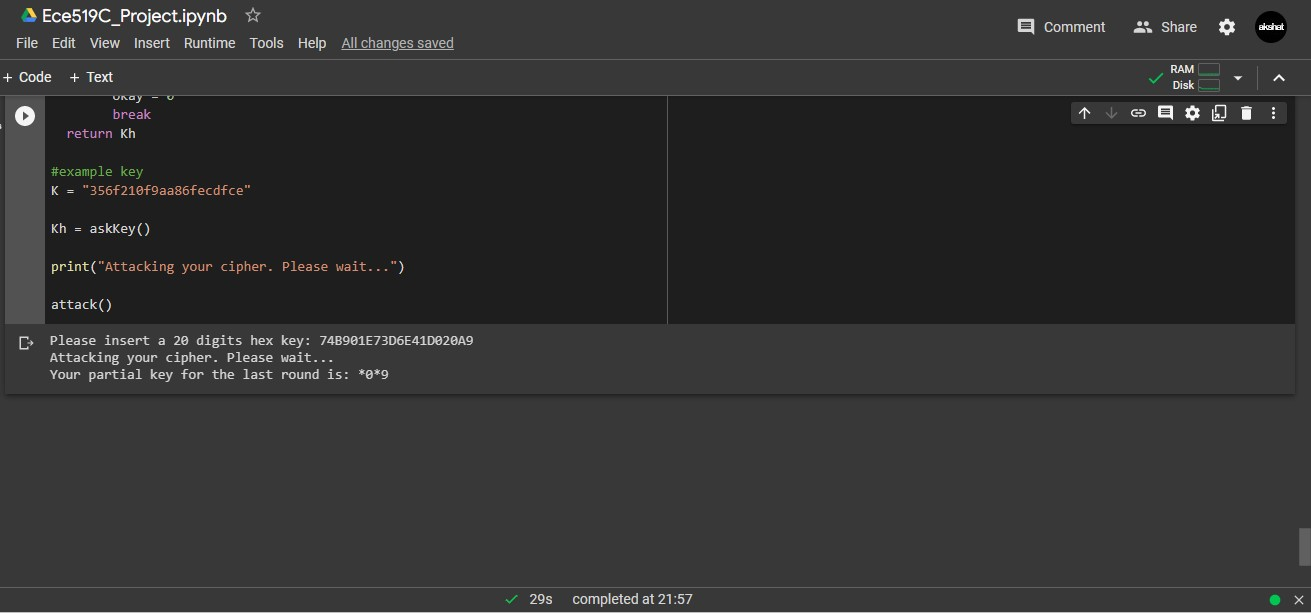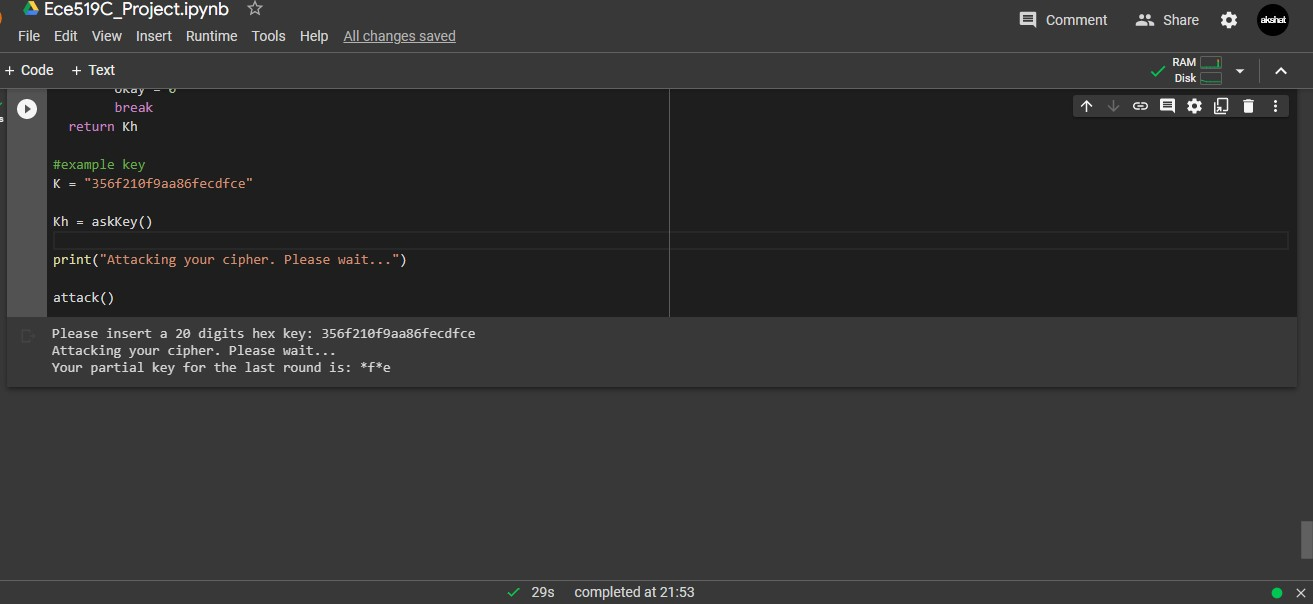